## Comparaison between random forest performence with EEG data and with EMG data

The goal is to see if the random forest is better with EEG data or with EMG data or with both. And if half of the data are enough to have a good performence.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')
import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(dataProcessing)
importlib.reload(splitData)

2023-07-14 16:14:26.228124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 16:14:26.305433: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 16:14:27.443400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/InputRelevance/../Library/splitData.py'>

In [10]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

In [11]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

In [12]:
# create two dataframe based on df, one containing the state and eeg data, the other containing the state and emg data
eeg_columns = ['rawState', 'state', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy','spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9' ]
# add the columns that contain the EMG 
eeg_columns.extend([col for col in df_train.columns if 'EEG' in col])
emg_columns = ['rawState', 'state']
# add the columns that contain the EEG
emg_columns.extend([col for col in df_train.columns if 'EMG' in col])
print(eeg_columns)
print(emg_columns)

['rawState', 'state', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy', 'spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9', 'EEGv', 'EEGv_mean2', 'EEGv_median2', 'EEGv_var2', 'EEGv_min2', 'EEGv_max2', 'EEGv_mean5', 'EEGv_median5', 'EEGv_var5', 'EEGv_min5', 'EEGv_max5', 'EEGv_mean10', 'EEGv_median10', 'EEGv_var10', 'EEGv_min10', 'EEGv_max10', 'EEGv_mean20', 'EEGv_median20', 'EEGv_var20', 'EEGv_min20', 'EEGv_max20', 'EEGv_mean50', 'EEGv_median50', 'EEGv_var50', 'EEGv_min50', 'EEGv_max50', 'EEGv_mean100', 'EEGv_median100', 'EEGv_var100', 'EEGv_min100', 'EEGv_max100', 'EEGv_log', 'EEGv^2', 'EEGv^3']
['rawState', 'state', 'EMGv', 'EMGv_mean2', 'EMGv_median2', 'EMGv_var2', 'EMGv_min2', 'EMGv_max2', 'EMGv_mean5', 'EMGv_median5', 'EMGv_var5', 'EMGv_min5', 'EMGv_max5', 'EMGv_mean10', 'EMGv_median10', 'EMGv_var10',

In [13]:
df_train_eeg = df_train[eeg_columns]
df_train_emg = df_train[emg_columns]

In [14]:
df_train_eeg.head()

,rawState,state,EEGv,spectral_flatness,spectral_centroid,spectral_entropy,spectral_rolloff_0.1,spectral_rolloff_0.2,spectral_rolloff_0.3,spectral_rolloff_0.4,...,EEGv_min50,EEGv_max50,EEGv_mean100,EEGv_median100,EEGv_var100,EEGv_min100,EEGv_max100,EEGv_log,EEGv^2,EEGv^3
42193,n,n,5.651267e-09,0.037996,7.999055,-5.462352,3.00,3.25,3.50,4.25,...,3.163010e-09,1.384542e-08,6.612668e-09,6.451626e-09,4.281250e-18,2.364665e-09,1.384542e-08,-18.991386,3.193682e-17,1.804835e-25
42194,n,n,5.775355e-09,0.037665,8.881247,-5.845767,2.00,4.25,5.25,6.25,...,3.163010e-09,1.384542e-08,6.608574e-09,6.451626e-09,4.286465e-18,2.364665e-09,1.384542e-08,-18.969666,3.335473e-17,1.926354e-25
42195,n,n,5.574350e-09,0.038589,7.547337,-5.372338,2.25,3.00,3.00,3.50,...,3.307773e-09,1.384542e-08,6.609775e-09,6.451626e-09,4.283808e-18,2.364665e-09,1.384542e-08,-19.005090,3.107338e-17,1.732139e-25
42196,n,n,7.475215e-09,0.032589,9.739439,-5.820230,2.75,4.25,6.75,7.50,...,3.307773e-09,1.384542e-08,6.602160e-09,6.451626e-09,4.264579e-18,2.364665e-09,1.384542e-08,-18.711673,5.587884e-17,4.177063e-25
42197,w,w,2.775207e-09,0.110582,11.632449,-6.148244,1.00,1.50,2.25,4.50,...,2.775207e-09,1.384542e-08,6.569704e-09,6.451626e-09,4.408036e-18,2.364665e-09,1.384542e-08,-19.702540,7.701776e-18,2.137403e-26


In [15]:
df_train_emg.head()

,rawState,state,EMGv,EMGv_mean2,EMGv_median2,EMGv_var2,EMGv_min2,EMGv_max2,EMGv_mean5,EMGv_median5,...,EMGv_min50,EMGv_max50,EMGv_mean100,EMGv_median100,EMGv_var100,EMGv_min100,EMGv_max100,EMGv_log,EMGv^2,EMGv^3
42193,n,n,1.728907e-10,1.937667e-10,1.937667e-10,8.716281e-22,1.728907e-10,2.146427e-10,2.325647e-10,2.308092e-10,...,1.201830e-10,6.475938e-10,2.659400e-10,2.277583e-10,2.615198e-20,1.201830e-10,1.102402e-09,-22.478361,2.989121e-20,5.167913e-30
42194,n,n,2.246210e-10,1.987559e-10,1.987559e-10,1.338023e-21,1.728907e-10,2.246210e-10,2.313270e-10,2.246210e-10,...,1.201830e-10,6.475938e-10,2.648453e-10,2.272239e-10,2.612110e-20,1.201830e-10,1.102402e-09,-22.216607,5.045459e-20,1.133316e-29
42195,n,n,2.220478e-10,2.233344e-10,2.233344e-10,3.323760e-24,2.220478e-10,2.246210e-10,2.256612e-10,2.220478e-10,...,1.433889e-10,6.475938e-10,2.657038e-10,2.272239e-10,2.597168e-20,1.201830e-10,1.102402e-09,-22.228129,4.930521e-20,1.094811e-29
42196,n,n,3.653322e-10,2.936900e-10,2.936900e-10,1.026523e-20,2.220478e-10,3.653322e-10,2.399069e-10,2.220478e-10,...,1.433889e-10,6.475938e-10,2.670035e-10,2.272239e-10,2.606094e-20,1.201830e-10,1.102402e-09,-21.730214,1.334676e-19,4.876003e-29
42197,w,w,3.787862e-10,3.720592e-10,3.720592e-10,9.051817e-23,3.653322e-10,3.787862e-10,2.727356e-10,2.246210e-10,...,1.433889e-10,6.475938e-10,2.683630e-10,2.272239e-10,2.617938e-20,1.201830e-10,1.102402e-09,-21.694049,1.434790e-19,5.434788e-29


In [16]:
#df_train_eeg = df_train_eeg.drop(columns=['mouse'])
#df_train_emg = df_train_emg.drop(columns=['mouse'])
#df_test = df_test.drop(columns=['mouse'])
#df_train_eeg = dataProcessing.rebalance_state(df_train_eeg, 13)
#df_train_emg = dataProcessing.rebalance_state(df_train_emg, 13)

In [17]:
df_test_eeg = df_test.copy()
df_test_eeg = df_test_eeg[eeg_columns]
df_test_emg = df_test.copy()
df_test_emg = df_test_emg[emg_columns]
x_train_eeg, x_test_eeg, y_train_eeg, y_test_eeg, le = splitData.encode_scale_data(df_train_eeg, df_test_eeg, 13, True)
x_train_emg, x_test_emg, y_train_emg, y_test_emg, le = splitData.encode_scale_data(df_train_emg, df_test_emg, 13, True)

#### Model for EEG dataset classification

In [18]:
rfc = BalancedRandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc.fit(x_train_eeg, y_train_eeg)
y_pred_eeg = rfc.predict(x_test_eeg)

/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site

[[263546   6611  11480]
 [  7943  29435   2449]
 [ 92820  66167 282253]]
              precision    recall  f1-score   support

           n       0.72      0.94      0.82    281637
           r       0.29      0.74      0.41     39827
           w       0.95      0.64      0.77    441240

    accuracy                           0.75    762704
   macro avg       0.65      0.77      0.67    762704
weighted avg       0.83      0.75      0.77    762704



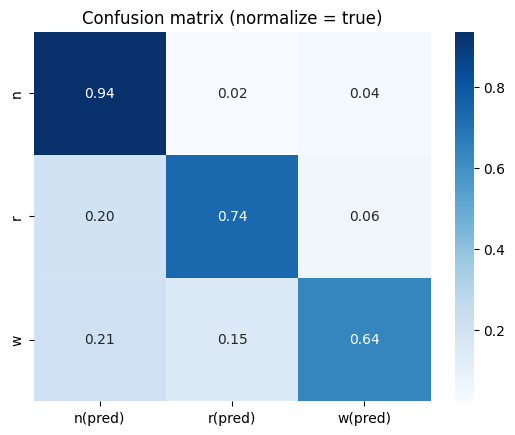

In [21]:

from sklearn.metrics import classification_report, confusion_matrix
pred_eeg = np.argmax(y_pred_eeg, axis=1)
test_eeg = np.argmax(y_test_eeg, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm_eeg = np.array(confusion_matrix(test_eeg, pred_eeg))
print(cm_eeg)

cm_eeg = np.array(confusion_matrix(test_eeg, pred_eeg, normalize='true')) # normalize = 'true' or 'pred'
confusion_eeg = pd.DataFrame(cm_eeg, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])


print(classification_report(test_eeg, pred_eeg, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion_eeg, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

#### Model for EMG dataset classification

In [22]:
rfc = BalancedRandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc.fit(x_train_emg, y_train_emg)
y_pred_emg = rfc.predict(x_test_emg)

/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site

[[193145  66692  21800]
 [ 19190  17618   3019]
 [105658   8624 326958]]
              precision    recall  f1-score   support

           n       0.61      0.69      0.64    281637
           r       0.19      0.44      0.27     39827
           w       0.93      0.74      0.82    441240

    accuracy                           0.71    762704
   macro avg       0.58      0.62      0.58    762704
weighted avg       0.77      0.71      0.73    762704



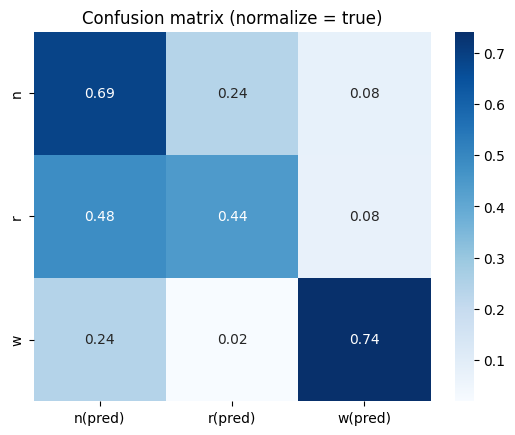

In [23]:

from sklearn.metrics import classification_report, confusion_matrix
pred_emg = np.argmax(y_pred_emg, axis=1)
test_emg = np.argmax(y_test_emg, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm_emg = np.array(confusion_matrix(test_emg, pred_emg))
print(cm_emg)

cm_emg = np.array(confusion_matrix(test_emg, pred_emg, normalize='true')) # normalize = 'true' or 'pred'
confusion_emg = pd.DataFrame(cm_emg, index=['n', 'r', 'w'], columns=['n(pred)', 'r(pred)', 'w(pred)'])


print(classification_report(test_emg, pred_emg, target_names=['n', 'r', 'w'], zero_division=0))

sns.heatmap(confusion_emg, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()